In [87]:
import os

import pandas as pd
import torch
import pickle

import numpy as np
from src import models, datasets, visualization
from configs import config_train
from torch.utils.data import DataLoader

In [88]:
def get_server_histories(model_dir, history_filename="history.pkl"):
    histories = []

    for client_dirs in os.listdir(model_dir):
        full_client_dir = os.path.join(model_dir, client_dirs)

        if os.path.isdir(full_client_dir):
            print(f"Opening history file {full_client_dir}/{history_filename}...")
            with open(f"{full_client_dir}/{history_filename}", 'rb') as f:
                history = pickle.load(f)

            histories.append(history)

    return histories

def get_average_curve(history):
    np_history = np.array(history)
    return np.mean(np_history, axis=0)

In [89]:
def get_evaluation_metrics(model_dir):
    eval_files = [filename for filename in os.listdir(model_dir) if "test_" in filename]

    eval_metrics = {}

    for filename in eval_files:
        filepath = os.path.join(model_dir, filename)

        test_set_name = filename[5:-14]
        with open(filepath, 'rb') as file:
            eval_metrics[test_set_name] = pickle.load(file)

    return eval_metrics

In [90]:
fixed_path = "C:\\Users\\JanFiszer\\data\\fixed_test"
selected_one_for_df = "C:\\Users\\JanFiszer\\data\\one_for_ds"

In [91]:
selected_loaders = {}
images_dict = {}
targets_dict = {}

for selected_dir in os.listdir(selected_one_for_df):
    selected_path = os.path.join(selected_one_for_df, selected_dir)
    testset = datasets.MRIDatasetNumpySlices([selected_path])
    dataloader = DataLoader(testset, batch_size=1)
    images_dict[selected_dir], targets_dict[selected_dir] = next(iter(dataloader))

In [92]:
images = list(images_dict.values())
targets = list(targets_dict.values())

In [93]:
def pred_on_different_ds(unet):
    return [unet(input_img).detach() for input_img in images]

In [94]:
client_names = ["Client MGH", "Client HGG", "Client LGG", "Client Oasis", "Client WU MINN"]
plot_labels = list(images_dict.keys())

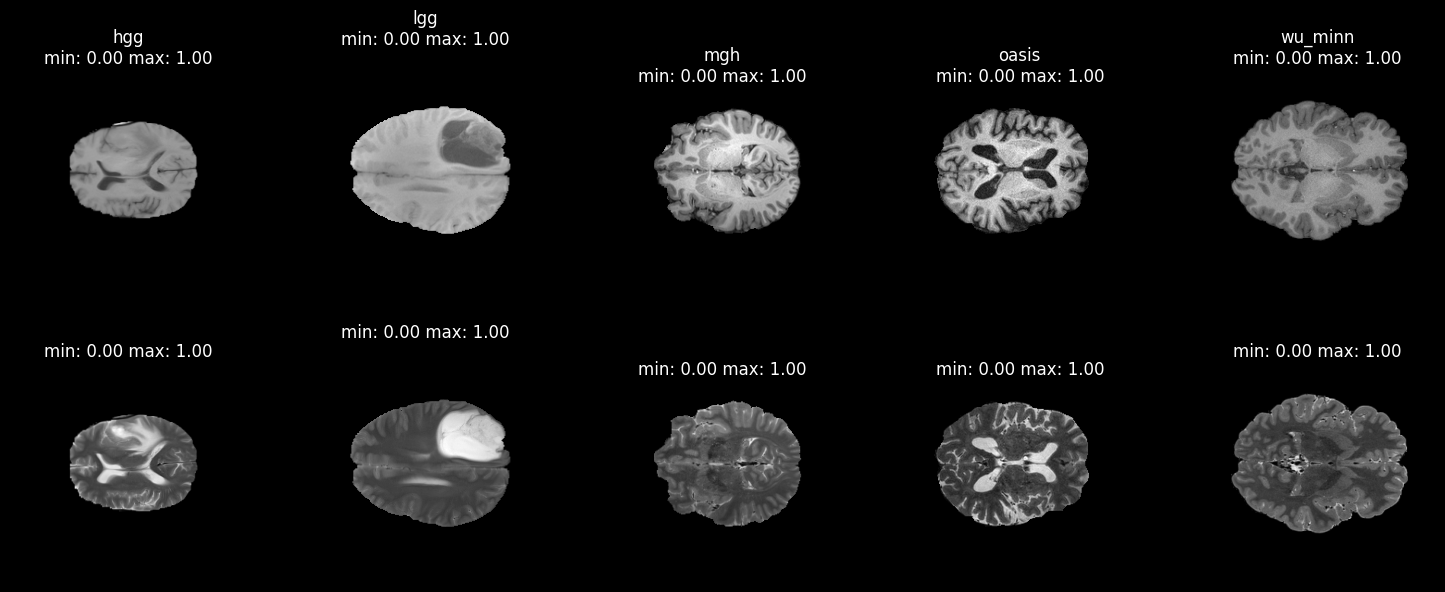

In [95]:
visualization.plot_pred([images, targets], plot_labels, pad=1)

In [96]:
ylim_zoomed_ssim = (0.5, 0.9)

## FedAvg

In [97]:
model_dir = "../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h"

In [98]:
histories_fedavg = get_server_histories(model_dir)

Opening history file ../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hcp_mgh_masks/history.pkl...
Opening history file ../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_lgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_oasis_26/history.pkl...
Opening history file ../trained_models/server/model-FED_AVG-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_wu_minn_26/history.pkl...


In [99]:
histories_fedavg[0].keys()

dict_keys(['loss', 'ssim', 'zoomed_ssim', 'pnsr', 'mse'])

In [100]:
loss_histories_fedavg = [history["loss"] for history in histories_fedavg]
ssim_histories_fedavg = [history["ssim"] for history in histories_fedavg]
pnsr_histories_fedavg = [history["pnsr"] for history in histories_fedavg]
mse_histories_fedavg = [history["mse"] for history in histories_fedavg]
zoomed_ssim_histories_fedavg = [history["zoomed_ssim"] for history in histories_fedavg]

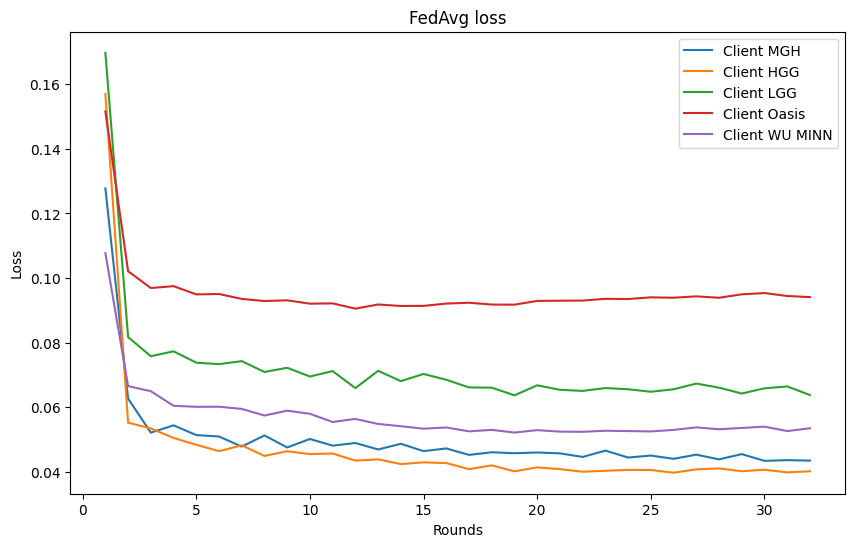

In [101]:
visualization.plot_learning_curves(loss_histories_fedavg, client_names, title="FedAvg loss")

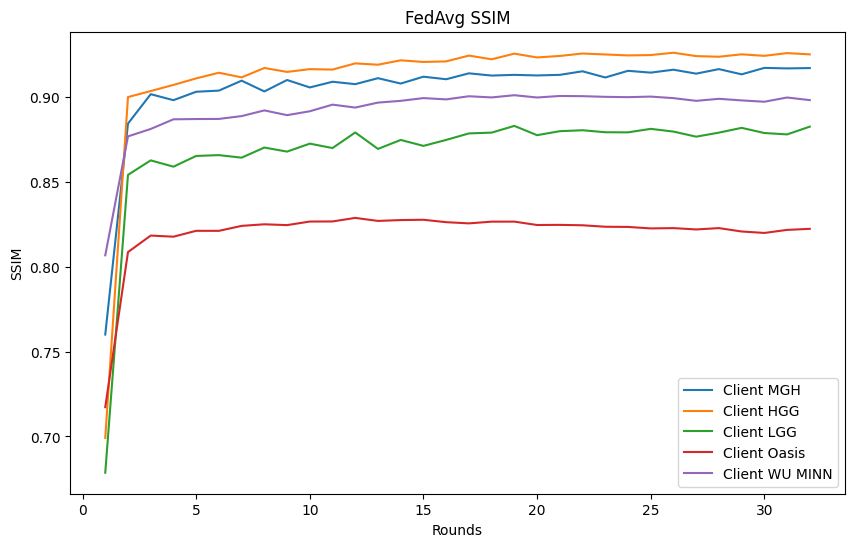

In [102]:
visualization.plot_learning_curves(ssim_histories_fedavg, client_names, title="FedAvg SSIM", ylabel="SSIM")

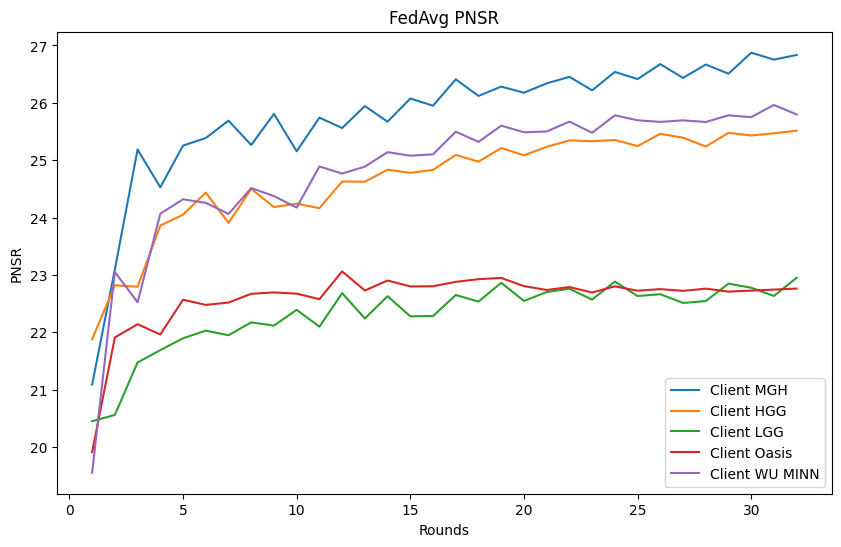

In [103]:
visualization.plot_learning_curves(pnsr_histories_fedavg, client_names, title="FedAvg PNSR", ylabel="PNSR")

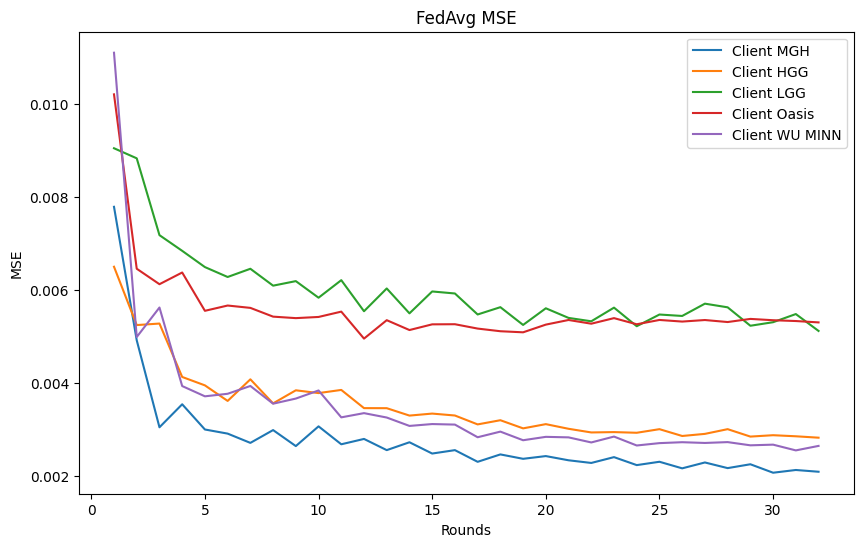

In [104]:
visualization.plot_learning_curves(mse_histories_fedavg, client_names, title="FedAvg MSE", ylabel="MSE")

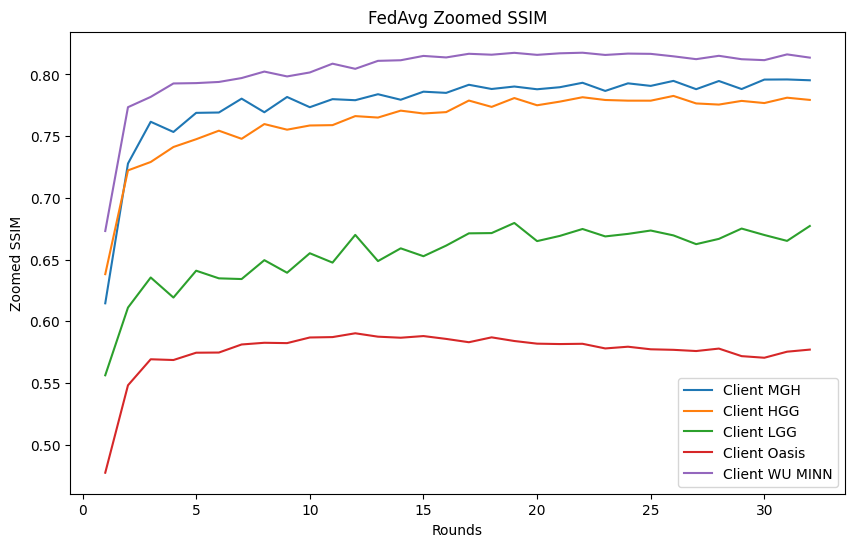

In [105]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedavg, client_names, title="FedAvg Zoomed SSIM", ylabel="Zoomed SSIM")

In [106]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [107]:
predictions_fedavg = pred_on_different_ds(unet)

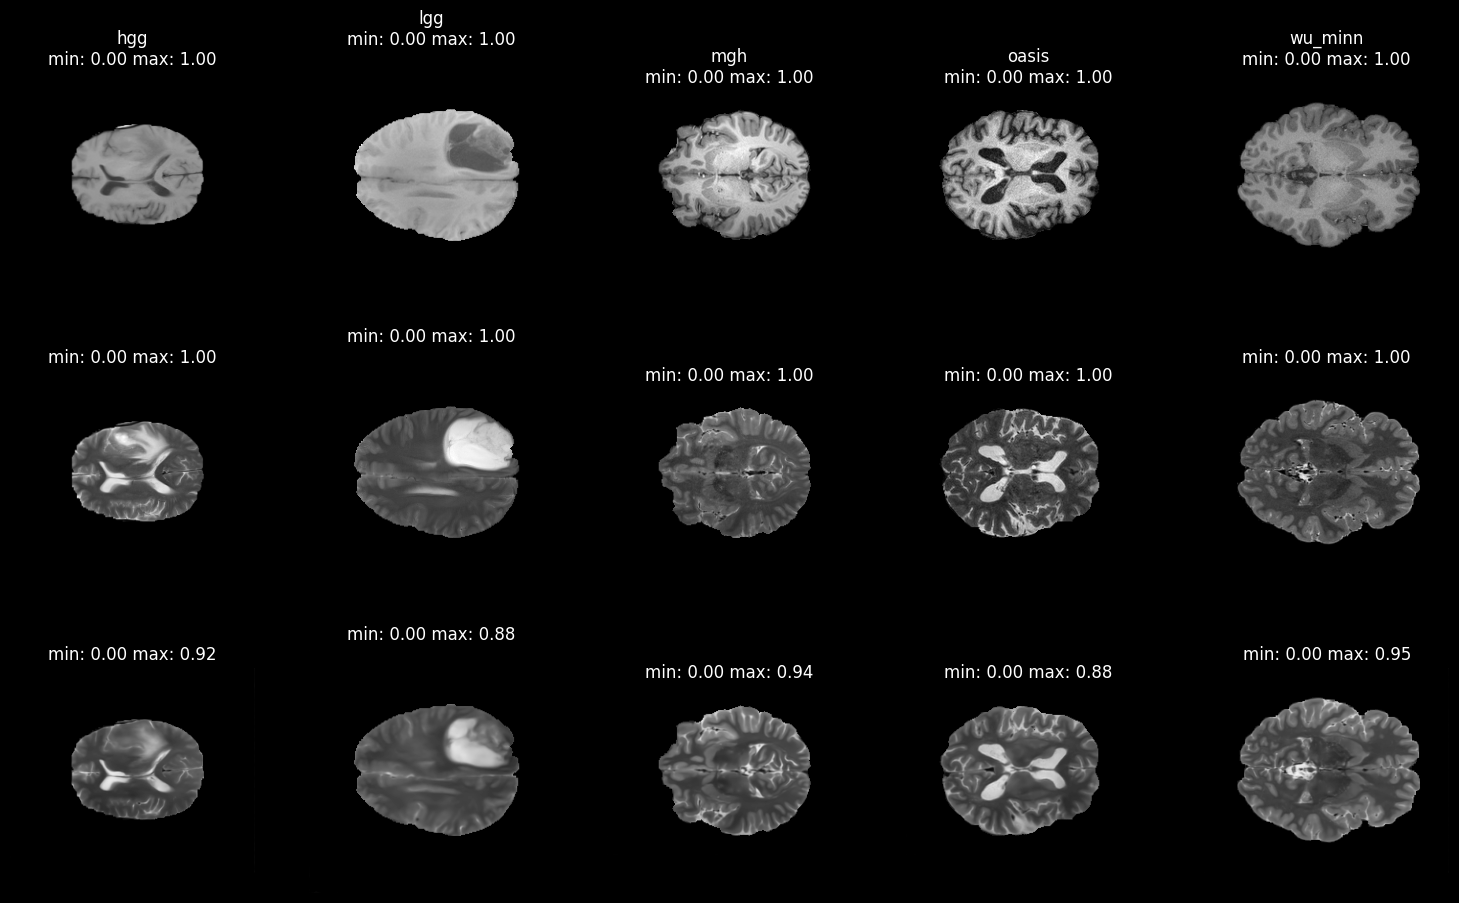

In [108]:
visualization.plot_pred([images, targets, predictions_fedavg], plot_labels)

In [109]:
eval_metric_fedavg = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedavg

,hcp_mgh_masks,hcp_wu_minn,hgg_50,lgg,oasis_125
loss,0.043559,0.054277,0.044014,0.049805,0.092985
ssim,0.917063,0.896514,0.916910,0.909372,0.824300
zoomed_ssim,0.795142,0.814755,0.756242,0.701520,0.564988
pnsr,26.820303,25.983419,26.099826,23.671225,22.909772
mse,0.002092,0.002534,0.002469,0.004491,0.005135


## FedProx

In [110]:
model_dir = "../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h"

In [111]:
histories_fedprox = get_server_histories(model_dir)

Opening history file ../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedProx_client_hcp_mgh_masks/history.pkl...
Opening history file ../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedProx_client_hgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedProx_client_lgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedProx_client_oasis_26/history.pkl...
Opening history file ../trained_models/server/model-FED_PROX-PROX-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedProx_client_wu_minn_26/history.pkl...


In [112]:
histories_fedprox[0].keys()

dict_keys(['loss', 'ssim', 'zoomed_ssim', 'pnsr', 'mse'])

In [113]:
loss_histories_fedprox = [history["loss"] for history in histories_fedprox]
ssim_histories_fedprox = [history["ssim"] for history in histories_fedprox]
pnsr_histories_fedprox = [history["pnsr"] for history in histories_fedprox]
mse_histories_fedprox = [history["mse"] for history in histories_fedprox]
zoomed_ssim_histories_fedprox = [history["zoomed_ssim"] for history in histories_fedprox]

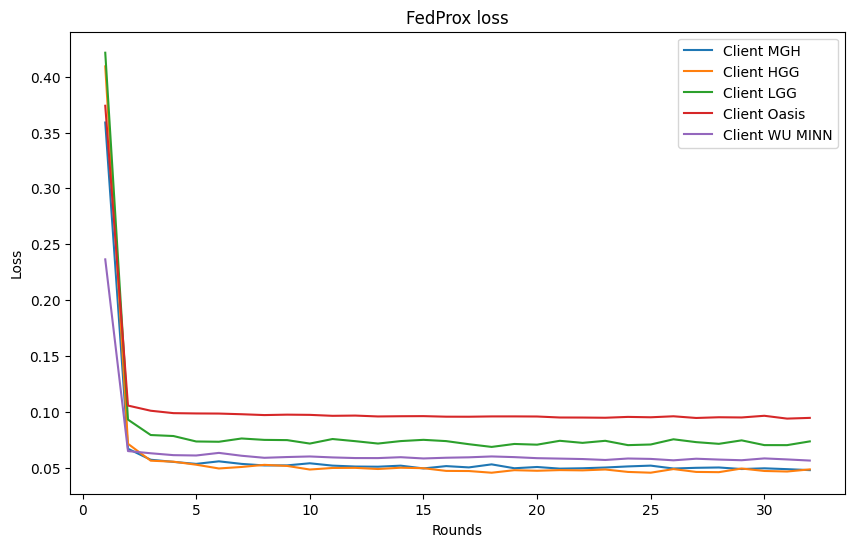

In [114]:
visualization.plot_learning_curves(loss_histories_fedprox, client_names, title="FedProx loss")

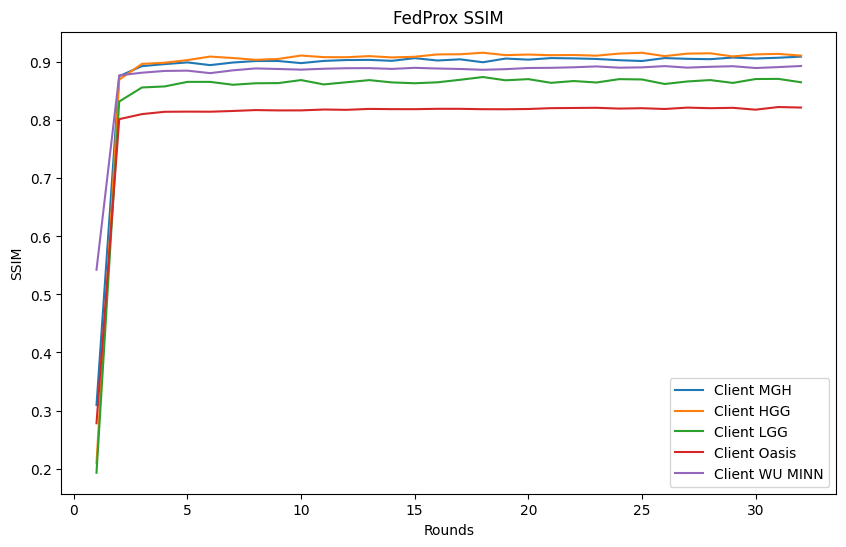

In [115]:
visualization.plot_learning_curves(ssim_histories_fedprox, client_names, title="FedProx SSIM", ylabel="SSIM")

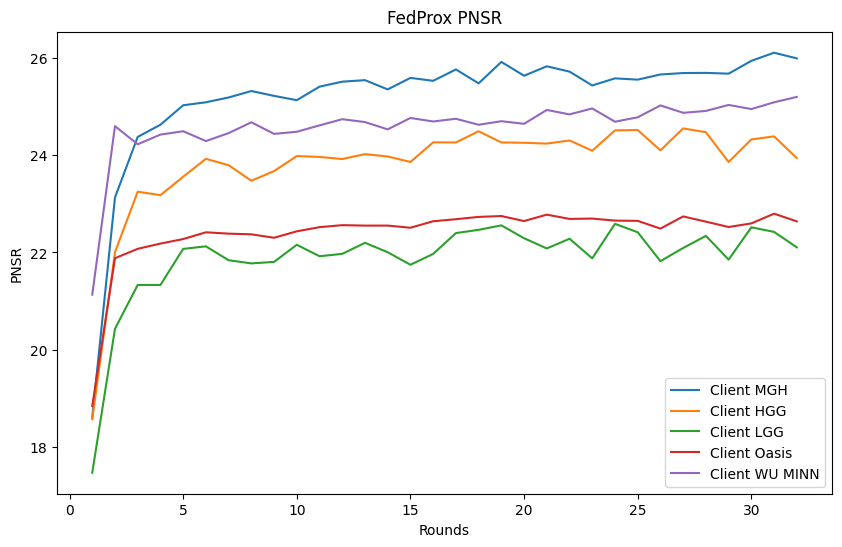

In [116]:
visualization.plot_learning_curves(pnsr_histories_fedprox, client_names, title="FedProx PNSR", ylabel="PNSR")

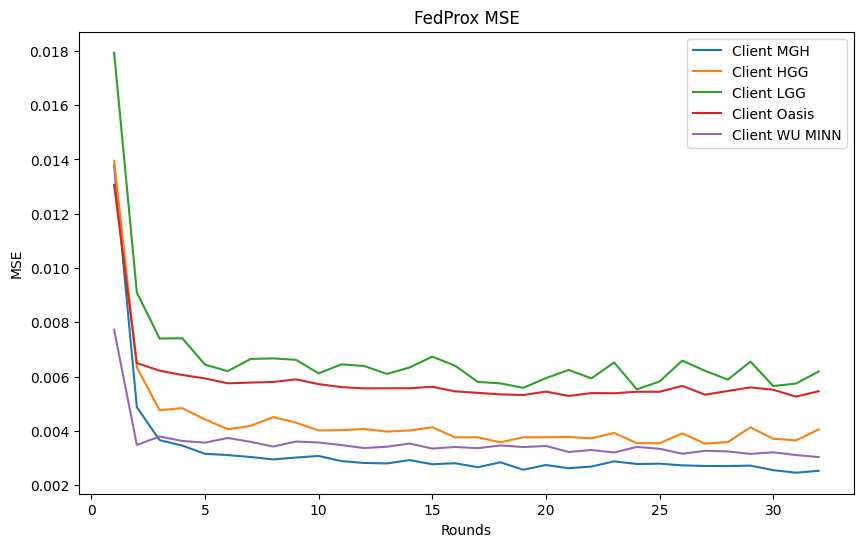

In [117]:
visualization.plot_learning_curves(mse_histories_fedprox, client_names, title="FedProx MSE", ylabel="MSE")

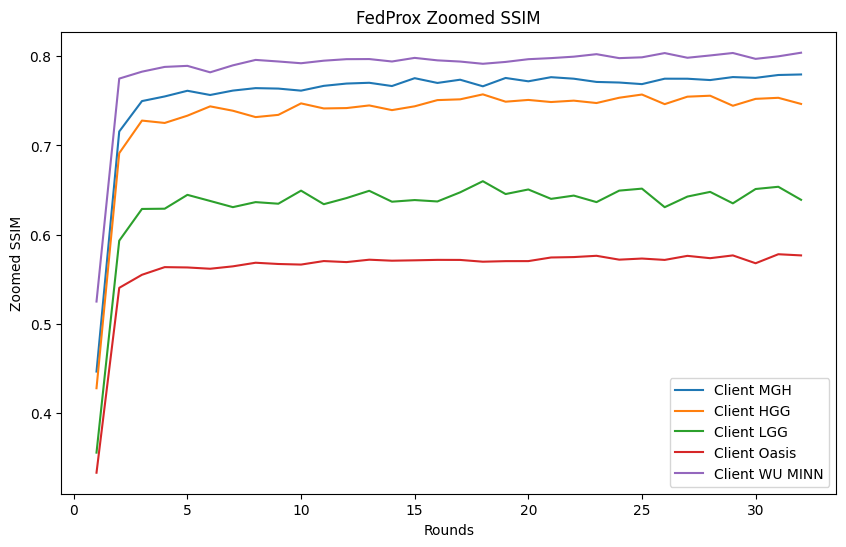

In [118]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedprox, client_names, title="FedProx Zoomed SSIM", ylabel="Zoomed SSIM")

In [119]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [120]:
predictions_fedprox = pred_on_different_ds(unet)

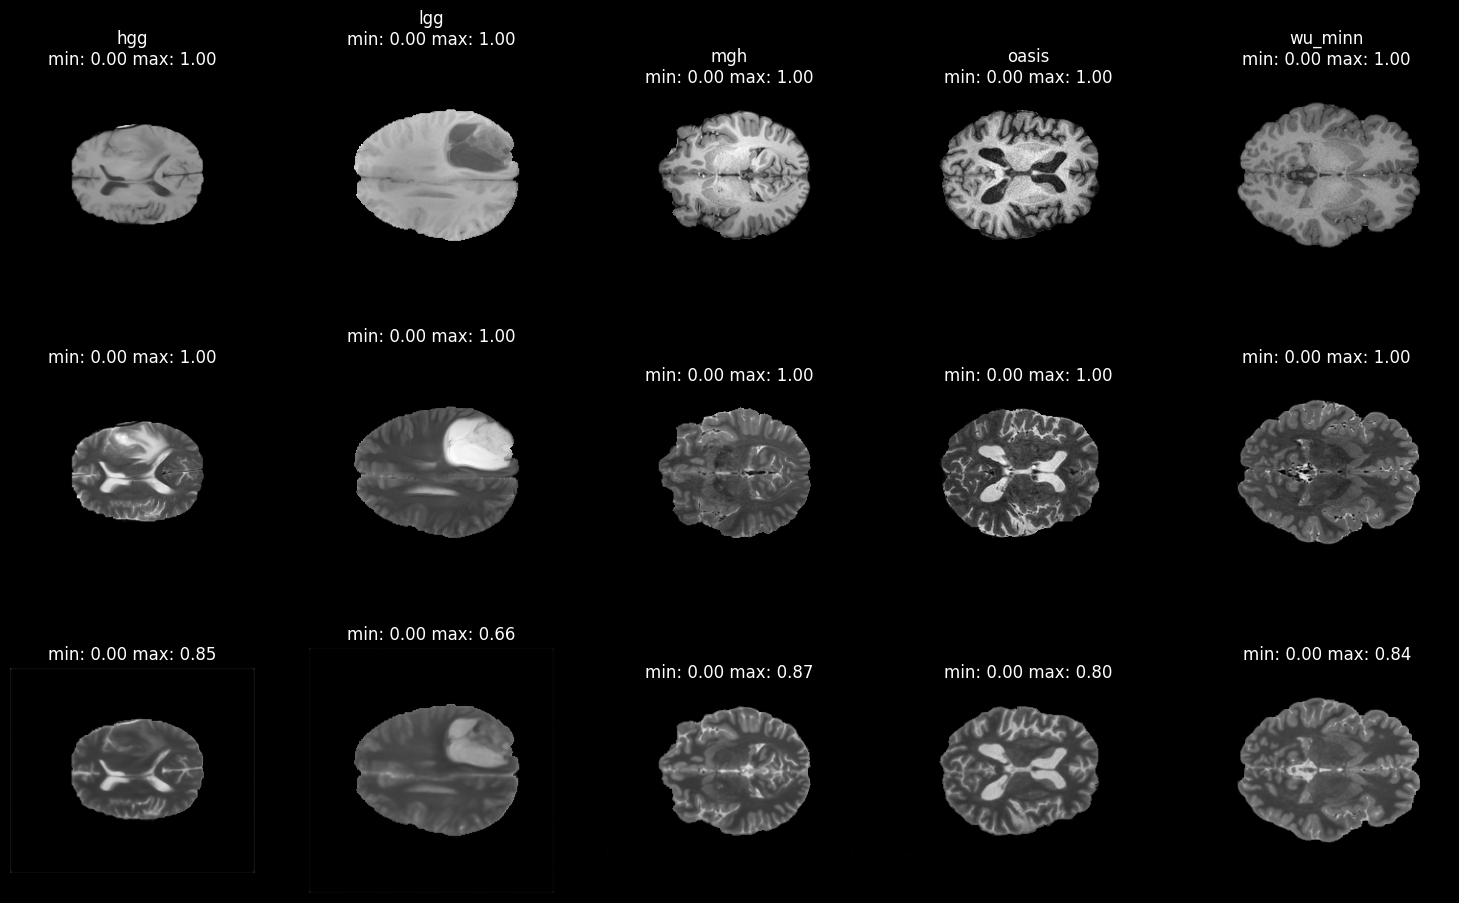

In [121]:
visualization.plot_pred([images, targets, predictions_fedprox], plot_labels)

In [122]:
eval_metric_fedprox = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedprox

,hcp_mgh_masks,hcp_wu_minn,hgg_50,lgg,oasis_125
loss,0.047705,0.058696,0.062121,0.063334,0.097410
ssim,0.909675,0.888770,0.886025,0.887114,0.816603
zoomed_ssim,0.779501,0.799606,0.673315,0.645064,0.546662
pnsr,25.966556,25.133061,22.928751,21.764226,22.447198
mse,0.002543,0.003081,0.005134,0.006891,0.005712


## FedAdagrad BN

In [123]:
model_dir = "../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h"

In [124]:
histories_fedadagrad = get_server_histories(model_dir)

Opening history file ../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hcp_mgh_masks/history.pkl...
Opening history file ../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_lgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_oasis_26/history.pkl...
Opening history file ../trained_models/server/model-FED_ADAGRAD-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_wu_minn_26/history.pkl...


In [125]:
histories_fedadagrad[0].keys()

dict_keys(['loss', 'ssim', 'zoomed_ssim', 'pnsr', 'mse'])

In [126]:
loss_histories_fedadagrad = [history["loss"] for history in histories_fedadagrad]
ssim_histories_fedadagrad = [history["ssim"] for history in histories_fedadagrad]
pnsr_histories_fedadagrad = [history["pnsr"] for history in histories_fedadagrad]
mse_histories_fedadagrad = [history["mse"] for history in histories_fedadagrad]
zoomed_ssim_histories_fedadagrad = [history["zoomed_ssim"] for history in histories_fedadagrad]

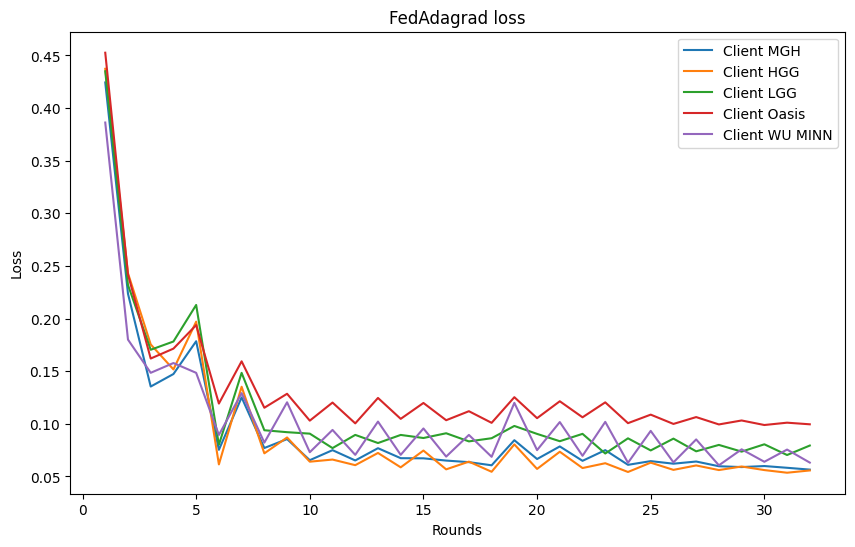

In [127]:
visualization.plot_learning_curves(loss_histories_fedadagrad, client_names, title="FedAdagrad loss")

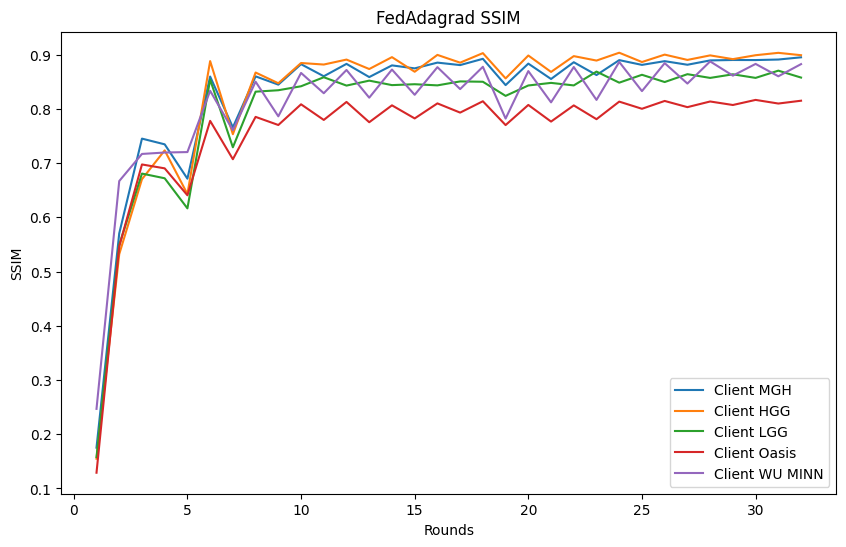

In [128]:
visualization.plot_learning_curves(ssim_histories_fedadagrad, client_names, title="FedAdagrad SSIM", ylabel="SSIM")

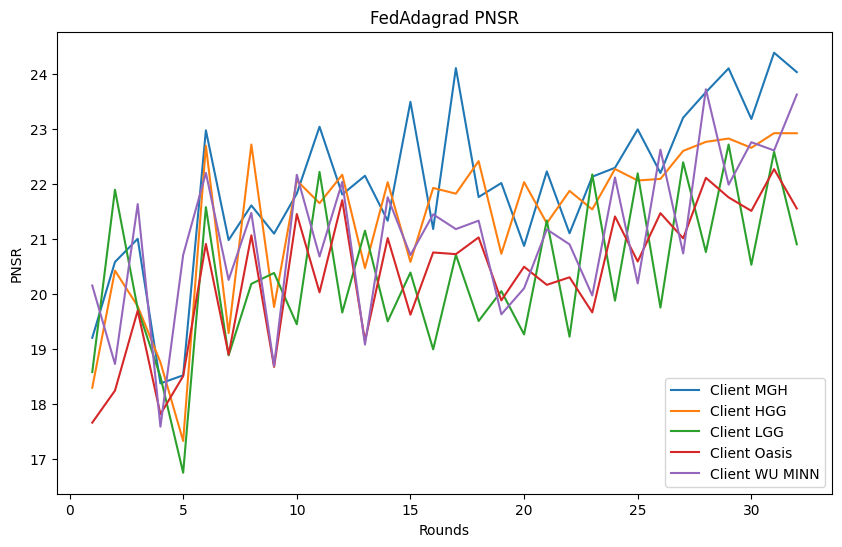

In [129]:
visualization.plot_learning_curves(pnsr_histories_fedadagrad, client_names, title="FedAdagrad PNSR", ylabel="PNSR")

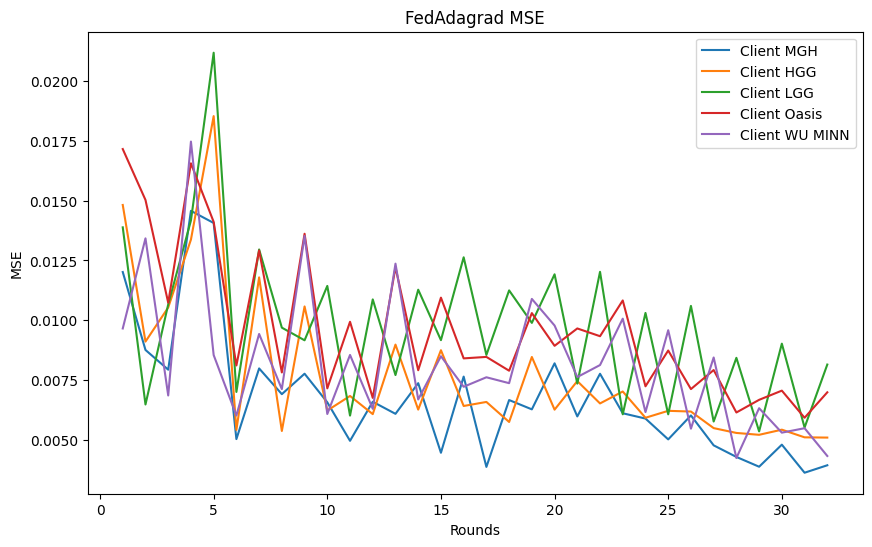

In [130]:
visualization.plot_learning_curves(mse_histories_fedadagrad, client_names, title="FedAdagrad MSE", ylabel="MSE")

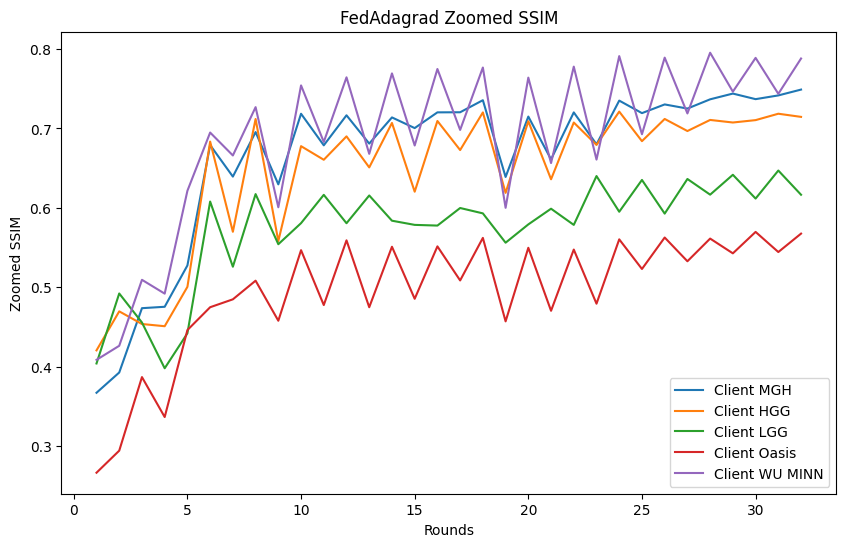

In [131]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedadagrad, client_names, title="FedAdagrad Zoomed SSIM", ylabel="Zoomed SSIM")

In [132]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [133]:
predictions_fedadagrad = pred_on_different_ds(unet)

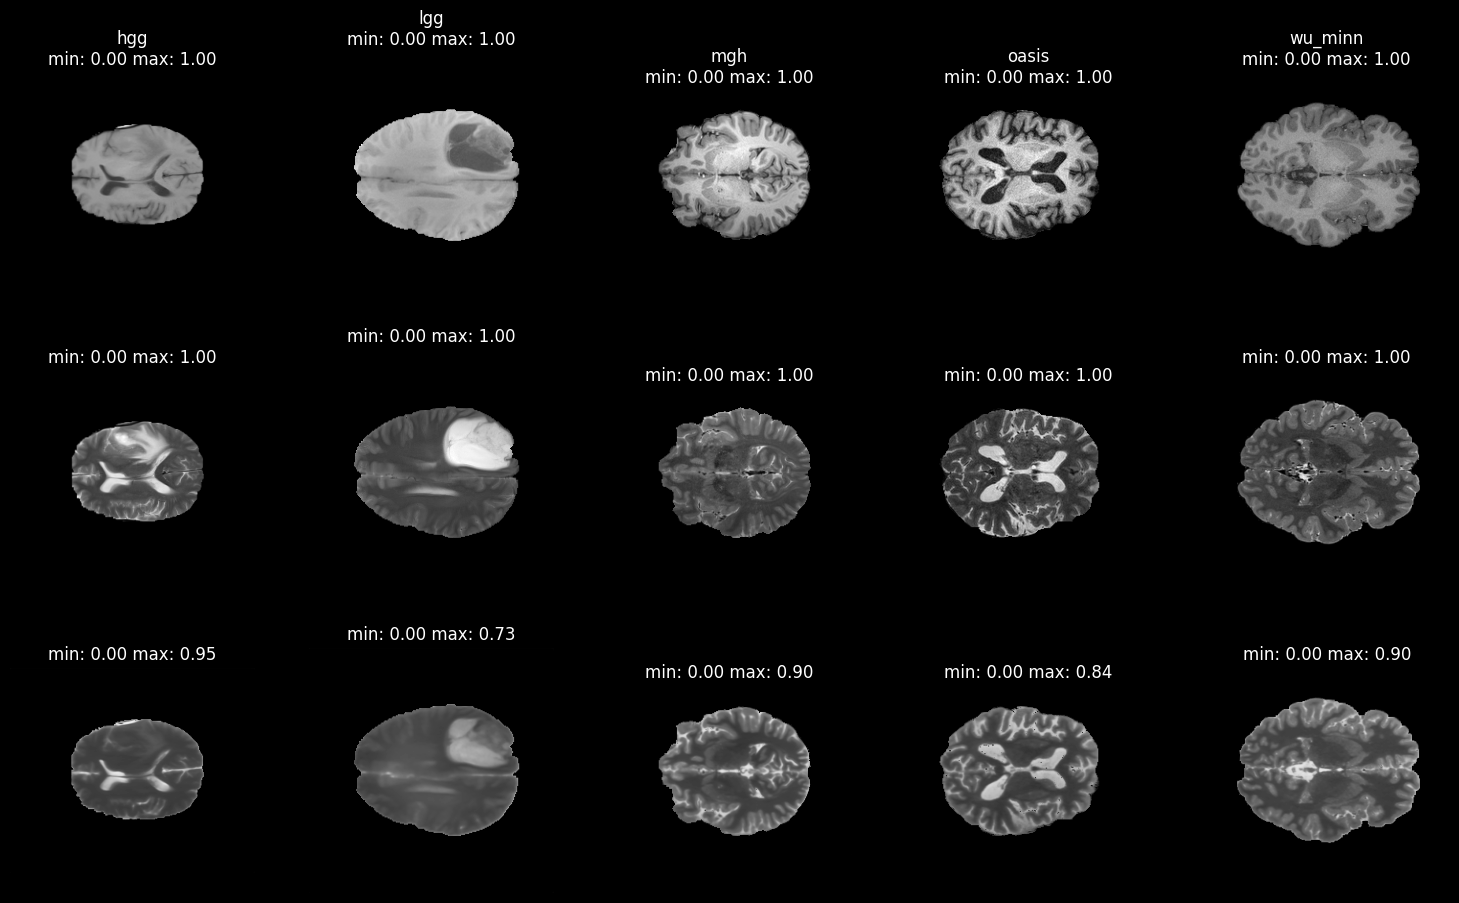

In [134]:
visualization.plot_pred([images, targets,  predictions_fedadagrad], plot_labels)

In [135]:
eval_metric_fedadagrad = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedadagrad

,hcp_mgh_masks,hcp_wu_minn,hgg_50,lgg,oasis_125
loss,0.056578,0.066360,0.066412,0.069124,0.102007
ssim,0.894784,0.876297,0.878572,0.877434,0.810369
zoomed_ssim,0.748508,0.781854,0.655270,0.611255,0.536901
pnsr,24.031561,23.475166,22.471307,21.158830,21.445142
mse,0.003971,0.004509,0.005699,0.007841,0.007192


## FedYogi BN

In [136]:
model_dir = "../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h"

In [137]:
histories_fedyogi = get_server_histories(model_dir)

Opening history file ../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hcp_mgh_masks/history.pkl...
Opening history file ../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_hgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_lgg_26/history.pkl...
Opening history file ../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_oasis_26/history.pkl...
Opening history file ../trained_models/server/model-FED_YOGI-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h\FedAvg_client_wu_minn_26/history.pkl...


In [138]:
histories_fedyogi[0].keys()

dict_keys(['loss', 'ssim', 'zoomed_ssim', 'pnsr', 'mse'])

In [139]:
loss_histories_fedyogi = [history["loss"] for history in histories_fedyogi]
ssim_histories_fedyogi = [history["ssim"] for history in histories_fedyogi]
pnsr_histories_fedyogi = [history["pnsr"] for history in histories_fedyogi]
mse_histories_fedyogi = [history["mse"] for history in histories_fedyogi]
zoomed_ssim_histories_fedyogi = [history["zoomed_ssim"] for history in histories_fedyogi]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedyogi, client_names, title="FedYogi loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedyogi, client_names, title="FedYogi SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedyogi, client_names, title="FedYogi PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedyogi, client_names, title="FedYogi MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedyogi, client_names, title="FedYogi Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedyogi = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedyogi], plot_labels)

In [ ]:
eval_metric_fedyogi = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedyogi

## FedAdam

In [ ]:
model_dir = "../trained_models/server/model-FED_ADAM-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-17h"

In [ ]:
histories_fedadam = get_server_histories(model_dir)

In [ ]:
histories_fedadam[0].keys()

In [ ]:
loss_histories_fedadam = [history["loss"] for history in histories_fedadam]
ssim_histories_fedadam = [history["ssim"] for history in histories_fedadam]
pnsr_histories_fedadam = [history["pnsr"] for history in histories_fedadam]
mse_histories_fedadam = [history["mse"] for history in histories_fedadam]
zoomed_ssim_histories_fedadam = [history["zoomed_ssim"] for history in histories_fedadam]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedadam, client_names, title="FedAdam loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedadam, client_names, title="FedAdam SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedadam, client_names, title="FedAdam PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedadam, client_names, title="FedAdam MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedadam, client_names, title="FedAdam Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedadam = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedadam], plot_labels)

In [ ]:
eval_metric_fedadam = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedadam

## FedAvgM

In [ ]:
model_dir = "../trained_models/server/model-fedavgm-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-20-12h"

In [ ]:
histories_fedavgm = get_server_histories(model_dir)

In [ ]:
histories_fedavgm[0].keys()

In [ ]:
loss_histories_fedavgm = [history["loss"] for history in histories_fedavgm]
ssim_histories_fedavgm = [history["ssim"] for history in histories_fedavgm]
pnsr_histories_fedavgm = [history["pnsr"] for history in histories_fedavgm]
mse_histories_fedavgm = [history["mse"] for history in histories_fedavgm]
zoomed_ssim_histories_fedavgm = [history["zoomed_ssim"] for history in histories_fedavgm]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedavgm, client_names, title="FedAvgM loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedavgm, client_names, title="FedAvgM SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedavgm, client_names, title="FedAvgM PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedavgm, client_names, title="FedAvgM MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedavgm, client_names, title="FedAvgM Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedavgm = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedavgm], plot_labels)

In [ ]:
eval_metric_fedavgm = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedavgm

# FedBN

In [ ]:
model_dir = "../trained_models/server/model-FED_AVG-lr0.001-rd32-ep4-BN-2023-09-05-14h"

In [ ]:
histories_fedbn = get_server_histories(model_dir)

In [ ]:
histories_fedbn[0].keys()

In [ ]:
loss_histories_fedbn = [history["loss"] for history in histories_fedbn]
ssim_histories_fedbn = [history["ssim"] for history in histories_fedbn]
pnsr_histories_fedbn = [history["pnsr"] for history in histories_fedbn]
mse_histories_fedbn = [history["mse"] for history in histories_fedbn]
zoomed_ssim_histories_fedbn = [history["zoomed_ssim"] for history in histories_fedbn]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedbn, client_names, title="FedBN loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedbn, client_names, title="FedBN SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedbn, client_names, title="FedBN PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedbn, client_names, title="FedBN MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedbn, client_names, title="FedBN Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/FedBN(batch_norm=NormalizationType.BN)_client_oasis_26/model.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedbn = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedbn], plot_labels)

In [ ]:
eval_metric_fedbn = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedbn

## FedCostW

In [ ]:
model_dir = "../trained_models/server/model-FED_COSTW-lr0.001-rd32-ep4-BN-2023-09-08-11h"

In [ ]:
histories_fedcost = get_server_histories(model_dir)

In [ ]:
histories_fedcost[0].keys()

In [ ]:
loss_histories_fedcost = [history["loss"] for history in histories_fedcost]
ssim_histories_fedcost = [history["ssim"] for history in histories_fedcost]
pnsr_histories_fedcost = [history["pnsr"] for history in histories_fedcost]
mse_histories_fedcost = [history["mse"] for history in histories_fedcost]
zoomed_ssim_histories_fedcost = [history["zoomed_ssim"] for history in histories_fedcost]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedcost, client_names, title="FedCostW loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedcost, client_names, title="FedCostW SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedcost, client_names, title="FedAvgM PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedcost, client_names, title="FedAvgM MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedcost, client_names, title="FedAvgM Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedcostw = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedcostw], plot_labels)

In [ ]:
eval_metric_fedcostw = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedcostw

## FedPID

In [ ]:
model_dir = "../trained_models/server/model-fedpid-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-21-10h"

In [ ]:
histories_fedpid = get_server_histories(model_dir)

In [ ]:
histories_fedpid[0].keys()

In [ ]:
loss_histories_fedpid = [history["loss"] for history in histories_fedpid]
ssim_histories_fedpid = [history["ssim"] for history in histories_fedpid]
pnsr_histories_fedpid = [history["pnsr"] for history in histories_fedpid]
mse_histories_fedpid = [history["mse"] for history in histories_fedpid]
zoomed_ssim_histories_fedpid = [history["zoomed_ssim"] for history in histories_fedpid]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedpid, client_names, title="FedPID loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedpid, client_names, title="FedPIDSSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedpid, client_names, title="FedPID PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedpid, client_names, title="FedPID MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedpid, client_names, title="FedPID Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedpid = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedpid], plot_labels)

In [ ]:
eval_metric_fedpid = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedpid

# FedTrimmed

In [ ]:
model_dir = "../trained_models/server/model-fedtrimmed-MSE_DSSIM-lr0.001-rd32-ep4-BN-2023-09-21-9h"

In [ ]:
histories_fedtrimmed = get_server_histories(model_dir)

In [ ]:
histories_fedtrimmed[0].keys()

In [ ]:
loss_histories_fedtrimmed = [history["loss"] for history in histories_fedtrimmed]
ssim_histories_fedtrimmed = [history["ssim"] for history in histories_fedtrimmed]
pnsr_histories_fedtrimmed = [history["pnsr"] for history in histories_fedtrimmed]
mse_histories_fedtrimmed = [history["mse"] for history in histories_fedtrimmed]
zoomed_ssim_histories_fedtrimmed = [history["zoomed_ssim"] for history in histories_fedtrimmed]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedtrimmed, client_names, title="fedtrimmed loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedtrimmed, client_names, title="fedtrimmedSSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedtrimmed, client_names, title="fedtrimmed PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedtrimmed, client_names, title="fedtrimmed MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedtrimmed, client_names, title="fedtrimmed Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedtrimmed = pred_on_different_ds(unet)

In [ ]:
visualization.plot_pred([images, targets, predictions_fedtrimmed], plot_labels)

In [ ]:
eval_metric_fedtrimmed = pd.DataFrame(get_evaluation_metrics(model_dir))
eval_metric_fedtrimmed

# Common plots

In [ ]:
fed_labels = ["FedAvgM", "FedAvg", "FedAdam", "FedYogi", "FedAdagrad", "FedProx", "FedBN", "FedCostW", "FedPID", "FedTrimmed"]

In [ ]:
to_plot = [zoomed_ssim_histories_fedavgm, zoomed_ssim_histories_fedavg, zoomed_ssim_histories_fedadam, zoomed_ssim_histories_fedyogi, zoomed_ssim_histories_fedadagrad, zoomed_ssim_histories_fedprox, zoomed_ssim_histories_fedbn, zoomed_ssim_histories_fedcost, zoomed_ssim_histories_fedpid, zoomed_ssim_histories_fedtrimmed]

In [ ]:
eval_metrics = [eval_metric_fedavgm, eval_metric_fedavg, eval_metric_fedadam, eval_metric_fedyogi, eval_metric_fedadagrad, eval_metric_fedprox, eval_metric_fedbn, eval_metric_fedcostw, eval_metric_fedpid, eval_metric_fedtrimmed]

In [ ]:
# fed_labels_no_fedbn = fed_labels.copy()
# fed_labels_no_fedbn.remove("FedBN")

metric_name = "zoomed_ssim"
specified_metric_eval = {}

for label, eval_metric in zip(fed_labels, eval_metrics):
    specified_metric_eval[label] = eval_metric.loc[metric_name]

pd.DataFrame(specified_metric_eval)

In [ ]:
metric_name = "mse"
specified_metric_eval = {}

for label, eval_metric in zip(fed_labels, eval_metrics):
    specified_metric_eval[label] = eval_metric.loc[metric_name]

pd.DataFrame(specified_metric_eval)

In [ ]:
# to_plot = [loss_histories_fedavgm, loss_histories_fedavg, loss_histories_fedadam, loss_histories_fedprox]
all_preditions = [predictions_fedavgm, predictions_fedavg, predictions_fedadam, predictions_fedyogi, predictions_fedadagrad, predictions_fedprox, predictions_fedbn, predictions_fedcostw, predictions_fedpid]

In [ ]:
average_curves = [get_average_curve(history) for history in to_plot]
visualization.plot_learning_curves(average_curves, fed_labels, title="Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
start_round = 10
visualization.plot_learning_curves(np.array(average_curves)[:, start_round:], fed_labels, title=f"Zoomed SSIM (starting from {start_round}th round)", ylabel="Zoomed SSIM", ylim=(0.65, 0.8))

## Oasis plot

In [ ]:
oasis_index = 3
to_plot_oasis = [histories_fedavgm[oasis_index],
                 histories_fedavg[oasis_index],
                 histories_fedadam[oasis_index],
                 histories_fedyogi[oasis_index],
                 histories_fedadagrad[oasis_index],
                 histories_fedprox[oasis_index],
                 histories_fedbn[oasis_index],
                 histories_fedcost[oasis_index]]

In [ ]:
histories_fedavgm[oasis_index]

In [ ]:
ssim_oasis = [history["zoomed_ssim"] for history in to_plot_oasis]

In [ ]:
visualization.plot_learning_curves(ssim_oasis, fed_labels, title="Zoomed SSIM for OASIS dataset", ylabel="Zoomed SSIM", linetypes=[(0, (3, 1, 1, 1))] * 8)

In [ ]:
start_round = 10
visualization.plot_learning_curves(np.array(ssim_oasis)[:, start_round:], fed_labels, title="Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
visualization.plot_pred([images, targets] + all_preditions, ["Input", "Target"] + fed_labels)

# Zoomed SSIM

## FedAvg

In [ ]:
model_dir = "../trained_models/server/model-FED_AVG-MSE_ZOOMED_DSSIM-lr0.001-rd32-ep4-BN-2023-09-08-13h"

In [ ]:
histories_fedavg_zoomed = get_server_histories(model_dir)

In [ ]:
histories_fedavg_zoomed[0].keys()

In [ ]:
loss_histories_fedavg_zoomed = [history["loss"] for history in histories_fedavg_zoomed]
ssim_histories_fedavg_zoomed = [history["ssim"] for history in histories_fedavg_zoomed]
pnsr_histories_fedavg_zoomed = [history["pnsr"] for history in histories_fedavg_zoomed]
mse_histories_fedavg_zoomed = [history["mse"] for history in histories_fedavg_zoomed]
zoomed_ssim_histories_fedavg_zoomed = [history["zoomed_ssim"] for history in histories_fedavg_zoomed]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedavg_zoomed, client_names, title="FedAvg Zoomed- loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedavg_zoomed, client_names, title="FedAvg Zoomed- SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedavg_zoomed, client_names, title="FedAvg Zoomed- PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedavg_zoomed, client_names, title="FedAvg Zoomed- MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedavg_zoomed, client_names, title="FedAvg Zoomed- zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

## FedCostW

In [ ]:
model_dir = "../trained_models/server/model-FED_COSTW-MSE_ZOOMED_DSSIM-lr0.001-rd32-ep4-BN-2023-09-12-10h"

In [ ]:
histories_fedcost = get_server_histories(model_dir)

In [ ]:
histories_fedcost[0].keys()

In [ ]:
loss_histories_fedcost = [history["loss"] for history in histories_fedcost]
ssim_histories_fedcost = [history["ssim"] for history in histories_fedcost]
pnsr_histories_fedcost = [history["pnsr"] for history in histories_fedcost]
mse_histories_fedcost = [history["mse"] for history in histories_fedcost]
zoomed_ssim_histories_fedcost = [history["zoomed_ssim"] for history in histories_fedcost]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedcost, client_names, title="FedCostW loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedcost, client_names, title="FedCostW SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedcost, client_names, title="FedAvgM PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedcost, client_names, title="FedAvgM MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedcost, client_names, title="FedAvgM Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.BN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions_fedcostw_zooomed = unet(images)

In [ ]:
visualization.plot_batch([images, target, predictions_fedcostw.detach(), predictions_fedcostw_zooomed.detach()], plot_labels + ["Predicted zoomed"])

# Group Normalization

## FedAdam

In [ ]:
model_dir = "../trained_models/server/model-FED_ADAM-lr0.001-rd32-ep4-GN-2023-09-07-17h"
# model_dir = "./trained_models/client/model-lr0.001-ep128-2023-07-26-18_17"

In [ ]:
histories_fedadam_gn = get_server_histories(model_dir)

In [ ]:
histories_fedadam_gn[0].keys()

In [ ]:
loss_histories_fedadam_gn = [history["loss"] for history in histories_fedadam_gn]
ssim_histories_fedadam_gn = [history["ssim"] for history in histories_fedadam_gn]
pnsr_histories_fedadam_gn = [history["pnsr"] for history in histories_fedadam_gn]
mse_histories_fedadam_gn = [history["mse"] for history in histories_fedadam_gn]
zoomed_ssim_histories_fedadam_gn = [history["zoomed_ssim"] for history in histories_fedadam_gn]

In [ ]:
visualization.plot_learning_curves(loss_histories_fedadam_gn, client_names, title="FedAdam GN loss")

In [ ]:
visualization.plot_learning_curves(ssim_histories_fedadam_gn, client_names, title="FedAdam SSIM", ylabel="SSIM")

In [ ]:
visualization.plot_learning_curves(pnsr_histories_fedadam_gn, client_names, title="FedAdam PNSR", ylabel="PNSR")

In [ ]:
visualization.plot_learning_curves(mse_histories_fedadam_gn, client_names, title="FedAdam MSE", ylabel="MSE")

In [ ]:
visualization.plot_learning_curves(zoomed_ssim_histories_fedadam_gn, client_names, title="FedAdam Zoomed SSIM", ylabel="Zoomed SSIM")

In [ ]:
unet = models.UNet(normalization=config_train.NormalizationType.GN)
unet.load_state_dict(torch.load(f"{model_dir}/round32.pth", map_location=torch.device('cpu')))

In [ ]:
predictions = unet(images)

In [ ]:
visualization.plot_batch([images, target, predictions.detach()], plot_labels)